In [1]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread, imread_collection_wrapper, concatenate_images

In [2]:
import sys
sys.path.append("../")
from config import TRAIN_PATH, VALIDATION_PATH

# Load data

In [3]:
img_file_pattern = "*.tif"
train_imgs_path = os.path.join(TRAIN_PATH, img_file_pattern)
"""
it is necessary to create custom imread collection function which reads images with the 'imread' function
in order to obtain the raw values from the tif image. 
The default imread_collection function returns images that are uncorrectly scaled between 0 and 255
"""
imread_collection_custom = imread_collection_wrapper(imread)
train_imgs = imread_collection_custom(train_imgs_path, conserve_memory=True)

# Feature extraction

## spectral features

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion

In [ ]:
class BaseFeatureExtractor(TransformerMixin):
    def __init__(self):
        self.pixels_axis = (1, 2)
    
    def fit(self, imgs, y=None):
        raise NotImplementedError
    
    def transform(self, imgs, y=None):
        raise NotImplementedError

class SpectralFeatureExtractor(BaseFeatureExtractor):
    """
    extracts mean and standard deviation of every color channel in the image (RGB)
    and the brightness, where brightness is defined as the mean of all color channels

    Parameters
    ----------
    imgs : numpy.ndarray
           set of images, each with 4 channels (B, G, R, NIR)
    """
    def __init__(self):
        super().__init__()
    
    def fit(self, imgs, y=None):
        return self
    
    def transform(self, imgs, y=None):
        imgs = imgs[:, :, :, :3] # extract color channels
        rgb_means = np.mean(imgs, axis=self.pixels_axis)
        brightness = np.mean(rgb_means, axis=1)
        brightness = np.reshape(brightness, (-1, 1))
        rgb_sds = np.std(imgs, axis=self.pixels_axis)

        return np.concatenate((rgb_means, brightness, rgb_sds), axis=1)

class NDVIFeatureExtractor(BaseFeatureExtractor):
    """
    extracts normalized difference vegatation index from multispectral image

    Parameters
    ----------
    imgs : numpy.ndarray
           set of images, each with 4 channels (B, G, R, NIR)
    """
    def __init__(self):
        super().__init__()
    
    def fit(self, imgs, y=None):
        return self
    
    def transform(self, imgs, y=None):
        red = imgs[:, :, :, 2]
        nir = imgs[:, :, :, 3]

        ndvi = (nir-red)/(nir+red)
        
        # scale ndvi between -1 and 1
        # scaler = MinMaxScaler(feature_range=(-1, 1)) 
        # ndvi = scaler.fit_transform(ndvi)

        ndvi_means = np.mean(ndvi, axis=self.pixels_axis)
        ndvi_sds = np.std(ndvi, axis=self.pixels_axis)
        ndvi_means = np.reshape(ndvi_means, (-1, 1))
        ndvi_sds = np.reshape(ndvi_sds, (-1, 1))
        return np.concatenate((ndvi_means, ndvi_sds), axis=1)
        

In [ ]:
feature_extractor = FeatureUnion(transformer_list=[
    ("spectral", SpectralFeatureExtractor()),
    ("ndvi", NDVIFeatureExtractor())
])

In [ ]:
# subset = concatenate_images(train_imgs[:1])
# features = feature_extractor.fit_transform(subset)

# model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# warm_start required for out-of-core learning (in batches)
classifier = RandomForestClassifier(n_estimators=500, warm_start=True)
system = Pipeline([
    ('features', feature_extractor),
    ('classifier', classifier)
])

In [ ]:
batch_size = 100
n_images = len(train_imgs)
for i in range(0, n_images, batch_size):
    batch = concatenate_images(train_imgs[i:i+batch_size])
    system.fit(batch)

# Testing

In [26]:
from helpers.utils import load_and_show_img, tif_to_rgb
from skimage.io import imshow
import matplotlib.pyplot as plt

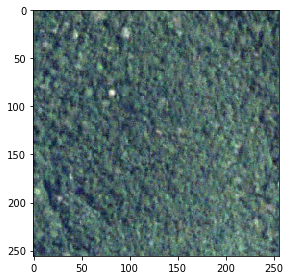

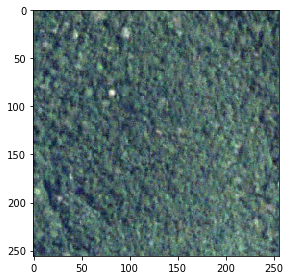

In [27]:
i = 3
load_and_show_img(f'train_{i}.tif')
plt.figure()
imshow(tif_to_rgb(train_imgs[i-1]))